In [82]:
## Projeto Classificar texto com Aprendizagem Supervisionada

# Pacotes

import re
import praw # Conectar com Api do Reddit
import config # Ajudar Conectar com Apis
import numpy as np
from sklearn.model_selection import train_test_split # Separar os Dados em treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer # Preparar a matriz com os dados de texto
from sklearn.decomposition import TruncatedSVD # Reduzir dimensionalidade

# Modelos de AP para análise
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import classification_report # Imprimir as métricas de avaliação
from sklearn.pipeline import Pipeline # Sequência de tarefas
from sklearn.metrics import confusion_matrix # Imprimir resultado final e avaliar performance

import matplotlib.pyplot as plt # Gráficos
import seaborn as sns

In [83]:
## Carregando dados

# Lista de temas que serão usados para buscas no reddit.
assuntos = ['datascience', 'machinelearning', 'physics', 'astrology', 'conspiracy']

# Função para carregar os dados
def carrega_dados():
    
    # Extraindo os dados via API
    api_reddit = praw.Reddit(
        client_id="you_id",
        client_secret="you_secrete",
        password="you_password",
        user_agent="you_app",
        username="you_username",
    )
    
    # Contando o número de caracteres usando Expressões regulares
    char_count = lambda post: len(re.sub('\W|\d','',post.selftext))
    
    # Definindo a condição para filtrar os posts (Retornar somente posts com 100 ou mais caract...
    mask = lambda post: char_count(post)>= 100
    
    # Resultados
    data = []
    labels =[]
    
    # Loop
    for i, assunto in enumerate(assuntos):
        
        # Extrair os posts
        subreddit_data = api_reddit.subreddit(assunto).new(limit=1000)
        
        # Filtra os posts que nao satisfazem nossa condição
        posts = [post.selftext for post in filter(mask,subreddit_data)]
        
        #Adiciona posts e labels às listas
        data.extend(posts)
        labels.extend([i]*len(posts))
        
        # Print
        print("Número de posts do assunto {} : {}".format(assunto, len(posts)),
              "\nUm dos posts extraídos: {}\n".format(posts[0][:600]) + "_"*80 + '\n')
        
    return data,labels

In [84]:
## Divisão em Dados de Treino e Teste

# Variáveis de controle
TEST_SIZE = 0.2
RANDOM_STATE = 0

# Função para split dos dados
def split_data():
        
        print("Splitting data...")
        print(" Split {} dos dados para teste e avaliação do modelo.".format(100*TEST_SIZE))
        
        # Split dos dados
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        
        print("{} amostras de test".format(len(y_test)))
        print("Splitting done!")
        
        return X_train, X_test, y_train, y_test

In [85]:
## Pré-Processamento de Dados e Extração de Atributos

# - Remove símbolos, números e strings semelhantes a url com pré-processador personalizado
# - Vetoriza texto usando o termo frequência inversa de frequência de documento
# - Reduz para valores principais usando decomposição de valor singular
# - Particiona dados e rótulos em conjuntos de treinamento  / validação

# Variáveis de controle
MIN_DOC_FREQ = 1
N_COMPONENTS = 1000
N_ITER = 30

# Função para pipeline de pré-processamento
def preprocessing_pipeline():
    
    # Remove caracteres não "Alfabéticos"
    patter = r'\W|\d|http.*\s+|www.*\s+'
    preprocessor = lambda text: re.sub(patter, ' ', text)
    
    # Vetorização TF-IDF
    vectorizer = TfidfVectorizer(preprocessor = preprocessor, stop_words = 'english',min_df = MIN_DOC_FREQ)
    
    # Reduzindo a dimensionalidade da matriz TF-IDF com Truncated, Recomendado quando temos matrizes esparsas, com valores 0, em outros casos usariamos PCA.
    decomposition = TruncatedSVD(n_components=N_COMPONENTS, n_iter=N_ITER)
    
    # Pipeline
    pipeline = [('tfidf', vectorizer), ('svd', decomposition)]
    
    return pipeline

In [86]:
## Seleção de Modelos

# Variáveis de Controle
N_NEIGHBORS = 4 # Vizinhos próximos
CV = 3 # Validações cruzadas

# Função para criar os modelos

def cria_modelos():
    
    modelo_1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
    modelo_2 = RandomForestClassifier(random_state=RANDOM_STATE)
    modelo_3 = LogisticRegressionCV(cv = CV, random_state=RANDOM_STATE)
    
    modelos = [("KNN",modelo_1),("RamdomForest",modelo_2),("LogReg",modelo_3)]
    
    return modelos

In [87]:
## Treinamento e Avaliação dos Modelos

# Função para treinamento e avaliação dos modelos

def treina_avalia(modelos, pipeline, X_train, X_test, y_train, y_test):
    
    resultados = []
    
    # loop
    for name,modelo in modelos:
        
        # Pipeline
        pipe = Pipeline(pipeline + [(name, modelo)])
        
        # Treinamento
        print("Treinando modelo {} com dados de treino...".format(name))
        pipe.fit(X_train, y_train)
        
        # Previsões com dados de Teste
        y_pred = pipe.predict(X_test)
        
        # Calcula as métricas
        report = classification_report(y_test, y_pred)
        print("Relatório de Classification\n", report)
        
        resultados.append([modelo, {'modelo': name, 'previsões': y_pred, 'report': report}])
        
    return resultados

In [88]:
## Executando o Pipeline Para Todos Os Modelos

# Pipeline de ML
if __name__ == '__main__':
    
    # Carrega Dados
    data, labels = carrega_dados()
    
    # Faz a divisão
    X_train, X_test, y_train, y_test = split_data()
    
    # Pipeline de pré-processamento
    pipeline = preprocessing_pipeline()
    
    # Cria os Modelos
    all_models = cria_modelos()
    
    # Treina e avalia os Modelos
    resultados = treina_avalia(all_models, pipeline, X_train, X_test, y_train, y_test)
    
print("Concluído com Sucesso")

Número de posts do assunto datascience : 735 
Um dos posts extraídos: Check out the resources your local library offers. I just got a library card and I'm kicking myself that I didn't do it sooner. I'm in Los Angeles and here's what's the LA Public Library provides access to:

* Udemy for free. 
* LinkedIn Learning for free.
* There are a limited number of all-access seats to Coursera programs, for free, through the CA State Library. 

Not to mention most textbooks are available as physical copies and e-books. 

If you're not in a big city, you can probably still access the e-resources for a large library program. For example, LAPL is free for any CA resident, o
________________________________________________________________________________

Número de posts do assunto machinelearning : 879 
Um dos posts extraídos: Hi, I wanted to educate myself on various PEFT techniques and my goal was to finetune some LLM on my RTX A4000 Laptop GPU, which has about 6GB free GPU RAM. Here is the link

C:\Users\jeyso\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jeyso\miniconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Relatório de Classification
               precision    recall  f1-score   support

           0       0.90      0.85      0.87       163
           1       0.80      0.92      0.86       168
           2       0.97      0.82      0.89        85
           3       0.98      0.93      0.95       101
           4       0.91      0.94      0.93       101

    accuracy                           0.89       618
   macro avg       0.91      0.89      0.90       618
weighted avg       0.90      0.89      0.89       618

Concluído com Sucesso


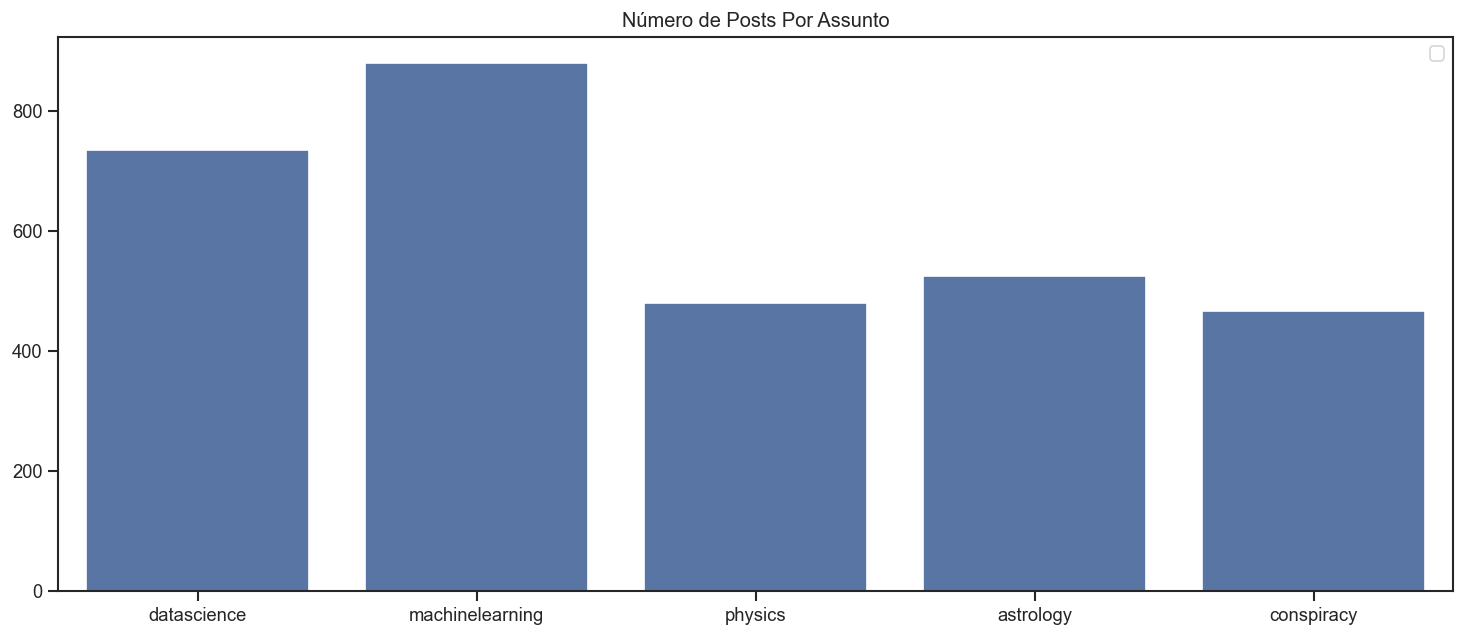

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       163
           1       0.61      0.86      0.71       168
           2       0.88      0.62      0.73        85
           3       0.90      0.87      0.88       101
           4       0.90      0.55      0.69       101

    accuracy                           0.75       618
   macro avg       0.81      0.73      0.75       618
weighted avg       0.78      0.75      0.75       618



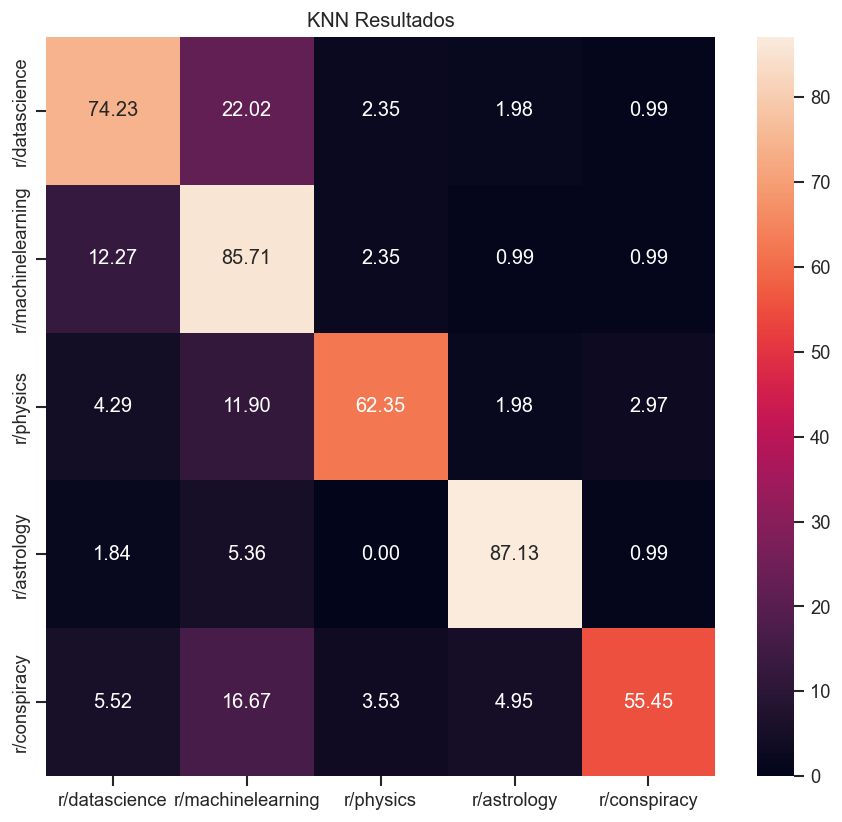

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.85      0.69      0.76       163
           1       0.66      0.92      0.76       168
           2       0.96      0.60      0.74        85
           3       0.94      0.87      0.90       101
           4       0.80      0.83      0.82       101

    accuracy                           0.79       618
   macro avg       0.84      0.78      0.80       618
weighted avg       0.82      0.79      0.79       618



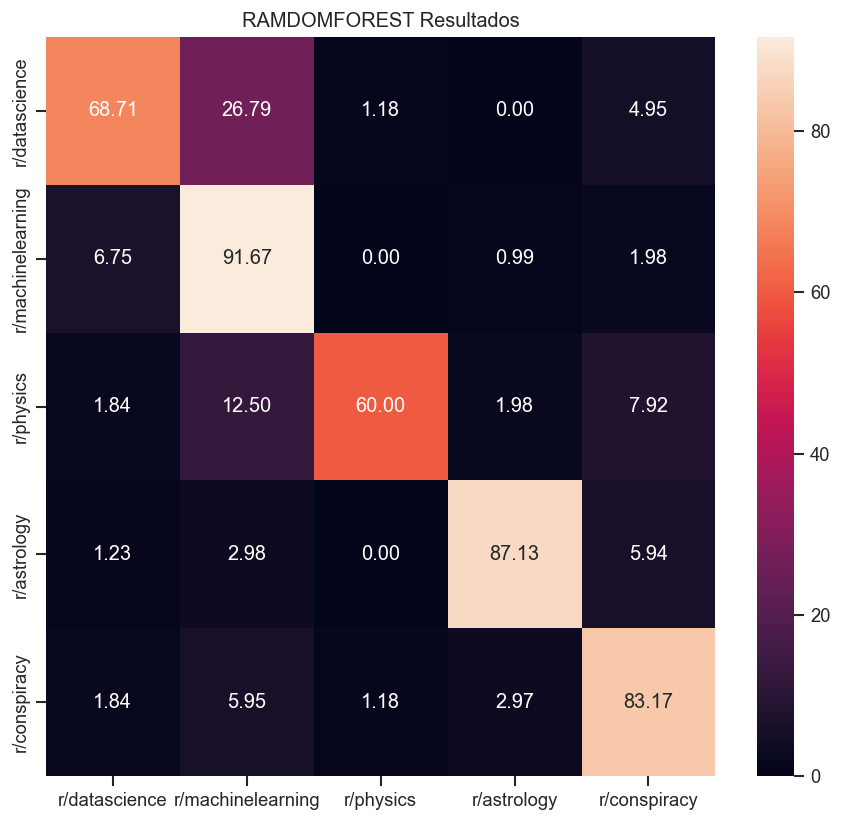

Relatório de Classificação
               precision    recall  f1-score   support

           0       0.90      0.85      0.87       163
           1       0.80      0.92      0.86       168
           2       0.97      0.82      0.89        85
           3       0.98      0.93      0.95       101
           4       0.91      0.94      0.93       101

    accuracy                           0.89       618
   macro avg       0.91      0.89      0.90       618
weighted avg       0.90      0.89      0.89       618



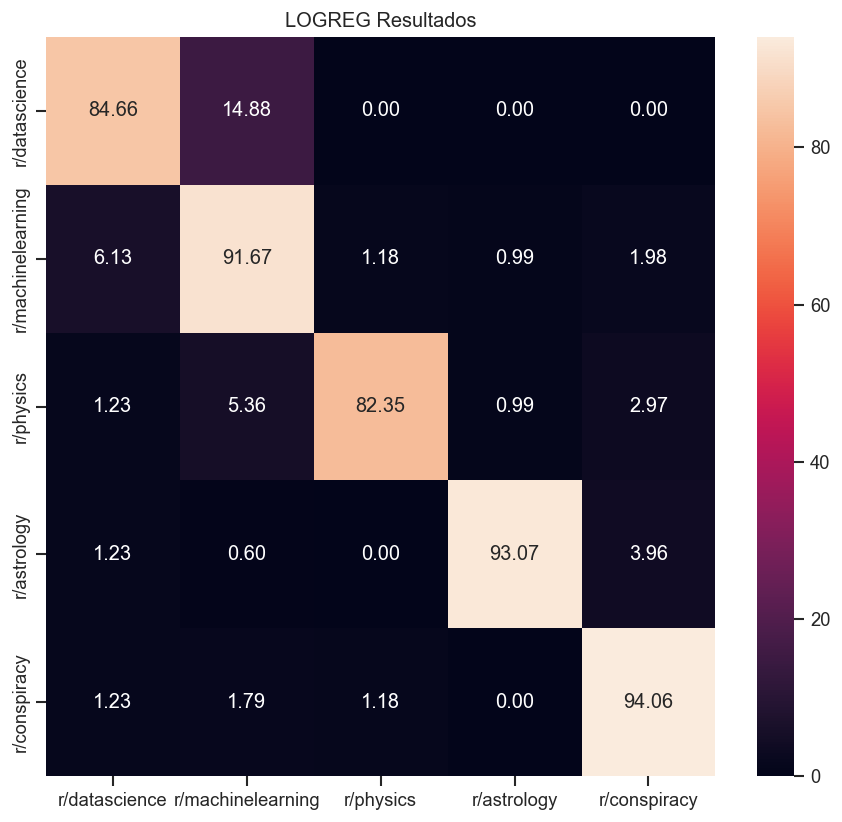

In [94]:
## Visualizando os Resuldados

def plot_distribution(): 
    """ Construir uma distribuição."""
    
    _, counts = np.unique(labels,return_counts=True)
    sns.set_theme(style="ticks")
    plt.figure(figsize = (15,6), dpi = 120)
    plt.title("Número de Posts Por Assunto")
    sns.barplot(x = assuntos, y = counts)
    plt.legend(' '.join([f.title(),f"- {c} posts"]) for f,c in zip(assuntos, counts))
    plt.show()

def plot_confusion(result):
    print("Relatório de Classificação\n", result[-1]['report'])
    y_pred = result[-1]['previsões']
    conf_matrix = confusion_matrix(y_test, y_pred)
    _, test_counts = np.unique(y_test,return_counts=True)
    conf_matrix_percent = conf_matrix / test_counts.transpose() * 100
    plt.figure(figsize = (9,8), dpi = 120)
    plt.title(result[-1]['modelo'].upper() + " Resultados")
    plt.xlabel("Valor Real")
    plt.ylabel("Previsões do Modelo")
    ticklabels = [f"r/{sub}" for sub in assuntos]
    sns.heatmap(data = conf_matrix_percent, xticklabels= ticklabels, yticklabels= ticklabels, annot= True, fmt='.2f')
    plt.show()
    
# Gráfico de avaliação
plot_distribution()

# Resultado do KNN
plot_confusion(resultados[0])

# Resultado RamdomForest
plot_confusion(resultados[1])

# Resultado Regressão Logística
plot_confusion(resultados[2])
    